In [46]:
import kagglehub
rhythmroy_sen12flood_flood_detection_dataset_path = kagglehub.dataset_download('rhythmroy/sen12flood-flood-detection-dataset')

print('Data source import complete.')


Data source import complete.


In [47]:
# General libraries
import os
import glob
import json
import random
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Torchvision and timm for pre-trained models and transforms
import torchvision.transforms as transforms
from torchvision import models
import timm

# Rasterio for reading TIFF images
!pip install rasterio --quiet
import rasterio

# PIL for image processing
from PIL import Image

# Mixed precision training (if desired)
from torch.amp import autocast, GradScaler

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print("Environment set up. Device:", device)


Environment set up. Device: cuda


Total TIFF files found: 36053
Sample file paths:
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/new.tif
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/0111/S1B_IW_GRDH_1SDV_20190202T182548_20190202T182613_014771_01B8C5_F9C2_corrected_VV.tif
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/0111/S2_2019-02-11_B05.tif
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/0111/S2_2019-02-11_B06.tif
/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD/0111/S2_2019-02-11_B11.tif


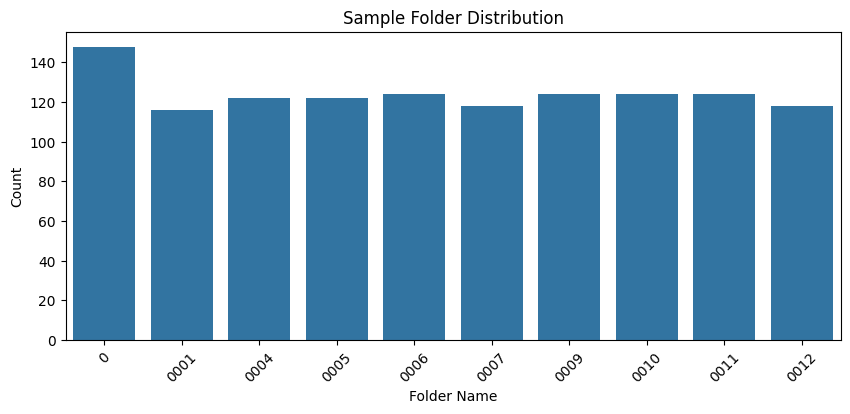

In [48]:
# Define dataset directory (adjust as needed)
data_dir = "/kaggle/input/sen12flood-flood-detection-dataset/SEN12FLOOD"

# List all TIFF files recursively
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print a sample of file paths to see the diversity (they may include Sentinel-1 and Sentinel-2 files)
print("Sample file paths:")
for f in tif_files[:5]:
    print(f)

# Optionally, plot a histogram of folder names to see the sensor or region distribution
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)

# Convert folder_counts (a Counter) into a DataFrame
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"])

# Sort by folder name or count if desired (here we just show the first 10 sorted by folder name)
df_folder_counts = df_folder_counts.sort_values("Folder").head(10)

plt.figure(figsize=(10, 4))
sns.barplot(data=df_folder_counts, x="Folder", y="Count")
plt.title("Sample Folder Distribution")
plt.xlabel("Folder Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [49]:
# Load JSON files for metadata (adjust paths if needed)
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

with open(s1_json_path, "r") as f:
    s1_data = json.load(f)
with open(s2_json_path, "r") as f:
    s2_data = json.load(f)

# Build label mapping from folder names to flood labels
flood_labels = {}
# Example logic for Sentinel-1 data (adjust based on actual JSON structure)
for folder, details in s1_data.items():
    flood_status = any(
        entry.get("FLOODING", False)
        for key, entry in details.items()
        if isinstance(entry, dict) and "FLOODING" in entry
    )
    flood_labels[folder] = int(flood_status)

# Update mapping using Sentinel-2 data if applicable
for folder, details in s2_data.items():
    flood_status = any(
        entry.get("FLOODING", False)
        for key, entry in details.items()
        if isinstance(entry, dict) and "FLOODING" in entry
    )
    flood_labels[folder] = int(flood_status)

# Verify mapping
print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]:
    print(f"Folder: {folder}, Flooding: {label}")

# Check overall label distribution in the dataset using folder names from TIFF files
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
print("Label Distribution in Dataset:", Counter(mapped_labels))


Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Label Distribution in Dataset: Counter({1: 24333, 0: 11720})


Sensor distribution:
sensor
Sentinel-2    26844
Sentinel-1     9208
Other             1
Name: count, dtype: int64


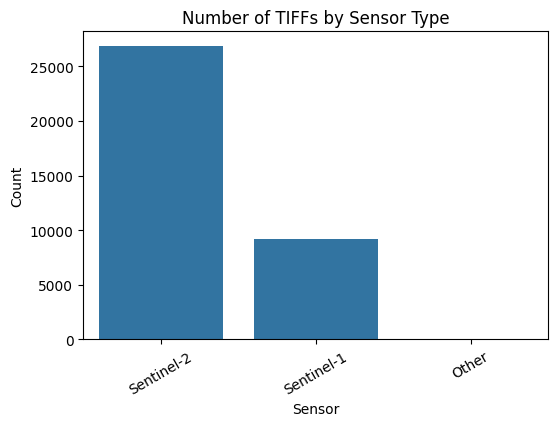

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Classify each TIFF by sensor type based on its path or filename
sensor_types = []
for path in tif_files:
    fname = os.path.basename(path)
    if "/S1" in path or fname.startswith("S1"):
        sensor_types.append("Sentinel-1")
    elif "/S2" in path or fname.startswith("S2"):
        sensor_types.append("Sentinel-2")
    else:
        sensor_types.append("Other")

# Build a DataFrame and count
df_sensors = pd.DataFrame({"path": tif_files, "sensor": sensor_types})
counts = df_sensors["sensor"].value_counts()

print("Sensor distribution:")
print(counts)

# Bar plot for visual inspection
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Number of TIFFs by Sensor Type")
plt.ylabel("Count")
plt.xlabel("Sensor")
plt.xticks(rotation=30)
plt.show()


In [51]:
import os
import pandas as pd

# We already have `tif_files` and `sensor_types` from before, but let's rebuild succinctly:
sensor_classification = []
for path in tif_files:
    if "/S1" in path or os.path.basename(path).startswith("S1"):
        sensor_classification.append("Sentinel-1")
    elif "/S2" in path or os.path.basename(path).startswith("S2"):
        sensor_classification.append("Sentinel-2")
    else:
        sensor_classification.append("Other")

df_sensors = pd.DataFrame({
    "filepath": tif_files,
    "sensor": sensor_classification
})

# Split into lists
sentinel1_files = df_sensors[df_sensors.sensor == "Sentinel-1"]["filepath"].tolist()
sentinel2_files = df_sensors[df_sensors.sensor == "Sentinel-2"]["filepath"].tolist()
other_files     = df_sensors[df_sensors.sensor == "Other"]["filepath"].tolist()

print(f"Sentinel‑1 count: {len(sentinel1_files)}")
print(f"Sentinel‑2 count: {len(sentinel2_files)}")
print(f"Other count:      {len(other_files)}")


Sentinel‑1 count: 9208
Sentinel‑2 count: 26844
Other count:      1


In [52]:
import rasterio
import numpy as np

def load_s2_true_color_stretched(prefix: str, band_map=None, pmin=2, pmax=98):
    """
    Given a prefix (folder) for Sentinel-2 single-band TIFFs, read bands 04,03,02,
    then apply a per-channel percentile stretch (default 2–98%) and return an
    8-bit RGB image.

    Parameters
    ----------
    prefix   : str
      The folder name (e.g. '0111') or any key into your s2_folder_groups dict.
    band_map : dict, optional
      Maps 'R','G','B' to band strings (default {'R':'04','G':'03','B':'02'}).
    pmin, pmax : float
      Percentiles for lower/upper clip.

    Returns
    -------
    np.ndarray
      uint8 RGB image of shape (H, W, 3).
    """
    if band_map is None:
        band_map = {'R':'04','G':'03','B':'02'}

    grp = s2_folder_groups[prefix]
    chans = {}
    for col, b in band_map.items():
        with rasterio.open(grp[b]) as src:
            chans[col] = src.read(1).astype(float)

    # Build the 3‐channel array
    arr = np.stack([chans['R'], chans['G'], chans['B']], axis=-1)

    # Per‐channel percentile stretch
    out = np.zeros_like(arr)
    for i, col in enumerate(['R','G','B']):
        band = arr[..., i]
        lo, hi = np.percentile(band, (pmin, pmax))
        band = np.clip(band, lo, hi)
        out[..., i] = ( (band - lo) / (hi - lo) * 255 )

    return out.astype(np.uint8)


In [53]:
import os
import random

# ---- Sentinel‑1 sampling ----
# We already have `sentinel1_files` and `flood_labels`
s1_flooded = [fp for fp in sentinel1_files    if flood_labels.get(os.path.basename(os.path.dirname(fp)),0)==1]
s1_non    = [fp for fp in sentinel1_files    if flood_labels.get(os.path.basename(os.path.dirname(fp)),0)==0]

n = 5
s1_flooded_samples = random.sample(s1_flooded, min(len(s1_flooded), n))
s1_non_samples     = random.sample(s1_non,    min(len(s1_non),    n))

print(f"Sentinel‑1: sampled {len(s1_flooded_samples)} flooded, {len(s1_non_samples)} non‑flooded images")

# ---- Sentinel‑2 sampling via B04 files ----
# Build list of all B04 band files
s2_b04 = [fp for fp in sentinel2_files if fp.endswith("_B04.tif")]

# Split by flood label (region folder)
s2_b04_flooded = [fp for fp in s2_b04 if flood_labels.get(os.path.basename(os.path.dirname(fp)),0)==1]
s2_b04_non     = [fp for fp in s2_b04 if flood_labels.get(os.path.basename(os.path.dirname(fp)),0)==0]

# Sample up to n from each
s2_b04_flooded_samples = random.sample(s2_b04_flooded, min(len(s2_b04_flooded), n))
s2_b04_non_samples     = random.sample(s2_b04_non,     min(len(s2_b04_non),     n))

print(f"Sentinel‑2: sampled {len(s2_b04_flooded_samples)} flooded, {len(s2_b04_non_samples)} non‑flooded B04 files")


Sentinel‑1: sampled 5 flooded, 5 non‑flooded images
Sentinel‑2: sampled 5 flooded, 5 non‑flooded B04 files


In [54]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

def load_s1_gray(fp):
    """Load Sentinel‑1 band1, stretch to 0–255 uint8."""
    with rasterio.open(fp) as src:
        arr = src.read(1).astype(float)
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    if hi>lo: arr=(arr-lo)/(hi-lo)
    else:     arr=np.zeros_like(arr)
    return (arr*255).astype(np.uint8)

def load_s2_true_color(b04_fp):
    """
    Given a B04 filepath, infer the B03 and B02 paths by filename,
    load all three, then per‑band min‑max stretch.
    """
    base = b04_fp[:-8]  # strip "_B04.tif"
    fR = b04_fp
    fG = base + "_B03.tif"
    fB = base + "_B02.tif"
    with rasterio.open(fR) as r, rasterio.open(fG) as g, rasterio.open(fB) as b:
        R = r.read(1).astype(float)
        G = g.read(1).astype(float)
        B = b.read(1).astype(float)
    out = np.stack([R,G,B], axis=-1)
    for i in range(3):
        ch = out[...,i]
        lo, hi = np.nanpercentile(ch, (2,98))
        ch = np.clip(ch, lo, hi)
        out[...,i] = (ch - lo)/(hi-lo) if hi>lo else np.zeros_like(ch)
    return (out*255).astype(np.uint8)

# Build figure
fig, axes = plt.subplots(4, 5, figsize=(18,16))

# Row 0: S1 flooded
for i, fp in enumerate(s1_flooded_samples):
    axes[0,i].imshow(load_s1_gray(fp), cmap="gray")
    axes[0,i].set_title("S1 Flooded")
    axes[0,i].axis("off")

# Row 1: S1 non‑flooded
for i, fp in enumerate(s1_non_samples):
    axes[1,i].imshow(load_s1_gray(fp), cmap="gray")
    axes[1,i].set_title("S1 Non‑Flooded")
    axes[1,i].axis("off")

# Row 2: S2 flooded
for i, fp in enumerate(s2_b04_flooded_samples):
    axes[2,i].imshow(load_s2_true_color(fp))
    axes[2,i].set_title("S2 Flooded")
    axes[2,i].axis("off")

# Row 3: S2 non‑flooded
for i, fp in enumerate(s2_b04_non_samples):
    axes[3,i].imshow(load_s2_true_color(fp))
    axes[3,i].set_title("S2 Non‑Flooded")
    axes[3,i].axis("off")

plt.suptitle("5 Samples Each: Sentinel‑1 Flooded/Non & Sentinel‑2 Flooded/Non", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Number of flooded images: 24333
Number of non-flooded images: 11720


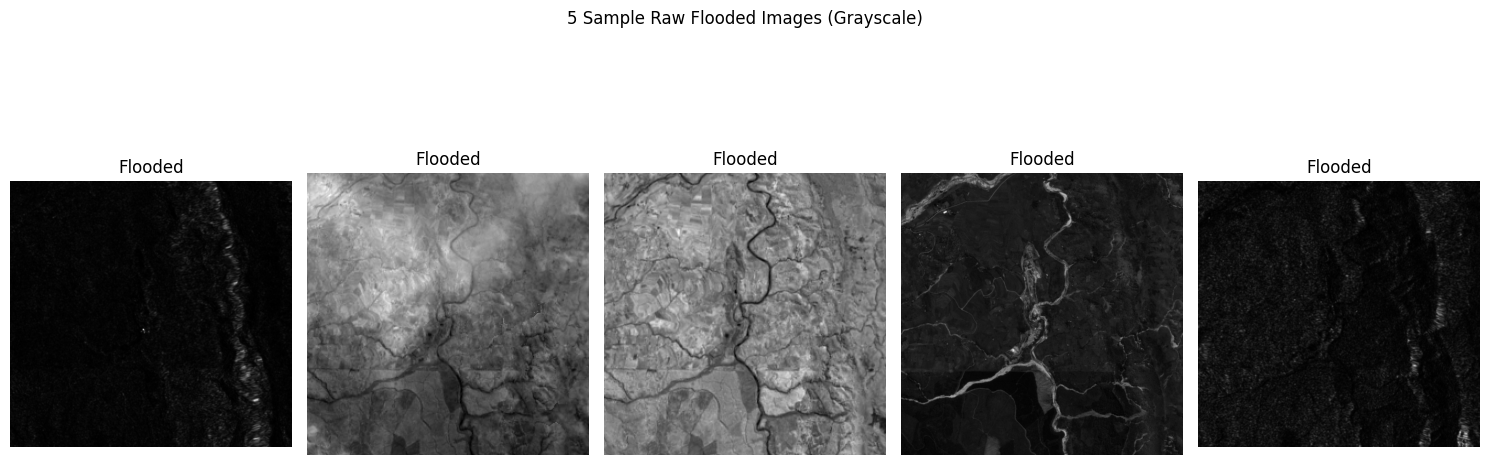

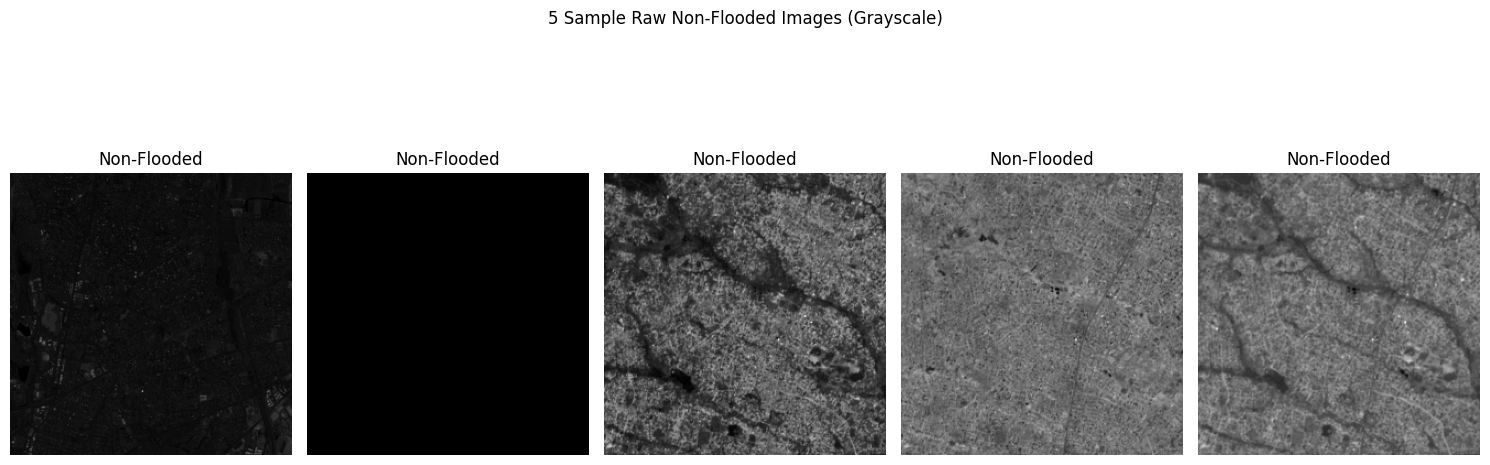

In [55]:
def load_raw_greyscale_image(image_filepath):
    """
    Reads a TIFF file and returns a grayscale image that is suitable for human interpretation.

    The function:
      - Opens the TIFF file using rasterio.
      - Reads only the first band of the image.
      - Applies a simple min-max stretch to scale pixel values to the range [0, 255].

    Parameters:
      image_filepath (str): The full file path to the TIFF image.

    Returns:
      np.ndarray: A 2D NumPy array (height x width) of type uint8 representing the grayscale image.
    """
    # Open the image file
    with rasterio.open(image_filepath) as src:
        # Read the first band (assumed to contain grayscale data)
        image_data = src.read(1).astype(float)

    # Compute minimum and maximum pixel values
    pixel_min = np.nanmin(image_data)
    pixel_max = np.nanmax(image_data)

    # Apply min-max stretching if possible
    if pixel_max > pixel_min:
        stretched_image = (image_data - pixel_min) / (pixel_max - pixel_min)
    else:
        stretched_image = np.zeros_like(image_data)

    # Scale to 0-255 and convert to uint8
    grayscale_image = (stretched_image * 255).clip(0, 255).astype(np.uint8)

    return grayscale_image

# Assume that 'tif_files' and 'flood_labels' are already defined in previous cells.
# Filter the TIFF files into flooded and non-flooded lists using the flood_labels mapping.
flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 1]
non_flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 0]

print("Number of flooded images:", len(flooded_files))
print("Number of non-flooded images:", len(non_flooded_files))

# Display 5 sample flooded grayscale images
plt.figure(figsize=(15, 6))
for idx, image_path in enumerate(flooded_files[:5]):
    grayscale_img = load_raw_greyscale_image(image_path)
    plt.subplot(1, 5, idx+1)
    plt.imshow(grayscale_img, cmap="gray")
    plt.title("Flooded")
    plt.axis("off")
plt.suptitle("5 Sample Raw Flooded Images (Grayscale)")
plt.tight_layout()
plt.show()

# Display 5 sample non-flooded grayscale images
plt.figure(figsize=(15, 6))
for idx, image_path in enumerate(non_flooded_files[:5]):
    grayscale_img = load_raw_greyscale_image(image_path)
    plt.subplot(1, 5, idx+1)
    plt.imshow(grayscale_img, cmap="gray")
    plt.title("Non-Flooded")
    plt.axis("off")
plt.suptitle("5 Sample Raw Non-Flooded Images (Grayscale)")
plt.tight_layout()
plt.show()


In [56]:
import os
import numpy as np
import rasterio
import cv2
from PIL import Image
import torch

def is_sentinel1(path: str) -> bool:
    fname = os.path.basename(path)
    return "/S1" in path or fname.startswith("S1")

def is_sentinel2(path: str) -> bool:
    fname = os.path.basename(path)
    return "/S2" in path or fname.startswith("S2")

def speckle_reduce(img: np.ndarray, ksize: int = 5) -> np.ndarray:
    """Median filter to reduce speckle noise (SAR)."""
    return cv2.medianBlur(img.astype(np.uint8), ksize)

def percentile_stretch(band: np.ndarray, pmin: float = 2, pmax: float = 98) -> np.ndarray:
    """Scale band to 0–255 by clipping to [pmin,pmax] percentile then stretching."""
    lo, hi = np.nanpercentile(band, (pmin, pmax))
    band = np.clip(band, lo, hi)
    band = (band - lo) / (hi - lo) if hi > lo else np.zeros_like(band)
    return (band * 255).astype(np.uint8)

def apply_clahe(band: np.ndarray, clip_limit: float = 2.0, tile_grid_size=(8,8)) -> np.ndarray:
    """Apply CLAHE to a single channel."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(band)

In [57]:
# Define transformations (e.g., resizing, converting to tensor, normalizing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust channels if needed
])

def preprocess_image(image_path: str) -> torch.Tensor:
    """
    Sensor‑aware read → enhancement → PIL → existing transform pipeline.
    You can drop this in place of your old preprocess_image and leave the rest of your notebook unchanged.
    """
    # 1) Read raw into bands
    with rasterio.open(image_path) as src:
        cnt = src.count
        if is_sentinel1(image_path):
            arr = src.read(1).astype(float)
            lo, hi = np.nanmin(arr), np.nanmax(arr)
            if hi > lo:
                # safe normalization
                norm = ((arr - lo) / (hi - lo) * 255).astype(np.uint8)
            else:
                # constant image → all zeros
                norm = np.zeros_like(arr, dtype=np.uint8)
            clean = speckle_reduce(norm)
            rgb = np.stack([clean]*3, axis=-1)

        elif is_sentinel2(image_path) and cnt >= 3:
            # assume bands B04=B, B03=G, B02=R ordering in filenames
            # adjust indices if necessary
            r = src.read(4).astype(float) if cnt>=4 else src.read(1).astype(float)
            g = src.read(3).astype(float) if cnt>=3 else src.read(1).astype(float)
            b = src.read(2).astype(float) if cnt>=3 else src.read(1).astype(float)
            # percentile stretch
            r, g, b = percentile_stretch(r), percentile_stretch(g), percentile_stretch(b)
            # CLAHE per channel
            r, g, b = apply_clahe(r), apply_clahe(g), apply_clahe(b)
            rgb = np.stack([r, g, b], axis=-1)
        else:
            # fallback single‐band → 3‐channel gray
            arr = src.read(1).astype(float)
            arr = (arr - arr.min()) / (arr.max() - arr.min()) if arr.max() > arr.min() else np.zeros_like(arr)
            arr = (arr * 255).astype(np.uint8)
            rgb = np.stack([arr]*3, axis=-1)

    # 2) Convert to PIL and hand off to your existing transform
    pil = Image.fromarray(rgb)
    return transform(pil)

def preprocess_image(image_path: str) -> torch.Tensor:
    """
    Sensor‑aware read → enhancement → PIL → existing transform pipeline.
    Falls back to a blank image if anything goes wrong reading the TIFF.
    """
    try:
        with rasterio.open(image_path) as src:
            cnt = src.count

            if is_sentinel1(image_path):
                # ---- Sentinel‑1: band1 → speckle filter → replicate to 3‐ch ----
                arr = src.read(1).astype(float)
                # normalize to 0–255 then median‐filter speckle
                norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
                clean = speckle_reduce(norm)
                rgb = np.stack([clean]*3, axis=-1)

            elif is_sentinel2(image_path) and cnt >= 3:
                # ---- Sentinel‑2: true‐color bands → percentile stretch → CLAHE ----
                # assume at least 4 bands so we can read 4,3,2
                r = src.read(4).astype(float)
                g = src.read(3).astype(float)
                b = src.read(2).astype(float)
                r = apply_clahe(percentile_stretch(r))
                g = apply_clahe(percentile_stretch(g))
                b = apply_clahe(percentile_stretch(b))
                rgb = np.stack([r, g, b], axis=-1)

            else:
                # ---- fallback: single‐band → normalize → replicate ----
                arr = src.read(1).astype(float)
                lo, hi = np.nanmin(arr), np.nanmax(arr)
                if hi > lo:
                    arr = ((arr - lo)/(hi - lo) * 255).astype(np.uint8)
                else:
                    arr = np.zeros_like(arr, dtype=np.uint8)
                rgb = np.stack([arr]*3, axis=-1)

        # Convert to PIL and hand off to your existing `transform`
        pil = Image.fromarray(rgb)
        return transform(pil)

    except Exception as e:

        # return a blank 3×224×224 tensor so your training continues
        return torch.zeros((3, 224, 224))


In [58]:
class FloodDataset(Dataset):
    def __init__(self, img_dir, label_map):
        # Recursively gather all .tif images
        self.img_paths = glob.glob(os.path.join(img_dir, "**/*.tif"), recursive=True)
        self.label_map = label_map

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        folder_name = os.path.basename(os.path.dirname(img_path))
        label = self.label_map.get(folder_name, 0)  # Default to 0 if not found
        image = preprocess_image(img_path)
        return image, label

# Instantiate the dataset
dataset = FloodDataset(data_dir, flood_labels)
print(f"Dataset created with {len(dataset)} samples.")


Dataset created with 36053 samples.


In [59]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Train: 25237, Val: 5407, Test: 5409


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [60]:
scaler = GradScaler()  # For mixed-precision training, if desired

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # Mixed precision context
        with autocast(device_type='cuda'):
            outputs = model(images)
            # If using a model like ViT, extract logits if needed
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            loss = criterion(outputs, labels)

        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
                loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# ResNet-50

In [61]:
# 1. Load and modify ResNet-50
resnet_model = models.resnet50(pretrained=True)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)  # 2 = binary classification
resnet_model = resnet_model.to(device)

# 2. Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.AdamW(resnet_model.parameters(), lr=1e-4)

# 3. Hyperparameters for training
num_epochs = 50
patience = 2
early_stop_threshold = 0.001

best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to store metrics for plotting
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 4. Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer_resnet, criterion, device)
    val_loss, val_acc = validate_epoch(resnet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Early stopping conditions
    if val_loss < early_stop_threshold:
        print("Validation loss is very low; stopping training early.")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} epochs; stopping training.")
            break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.2MB/s]
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-364667895

Epoch 1/50
Train Loss: 0.2101 | Train Acc: 0.8960
Val   Loss: 0.1515 | Val   Acc: 0.9181


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

Epoch 2/50
Train Loss: 0.1270 | Train Acc: 0.9355
Val   Loss: 0.8202 | Val   Acc: 0.8348


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

Epoch 3/50
Train Loss: 0.1087 | Train Acc: 0.9431
Val   Loss: 0.1707 | Val   Acc: 0.9160
Validation loss did not improve for 2 epochs; stopping training.


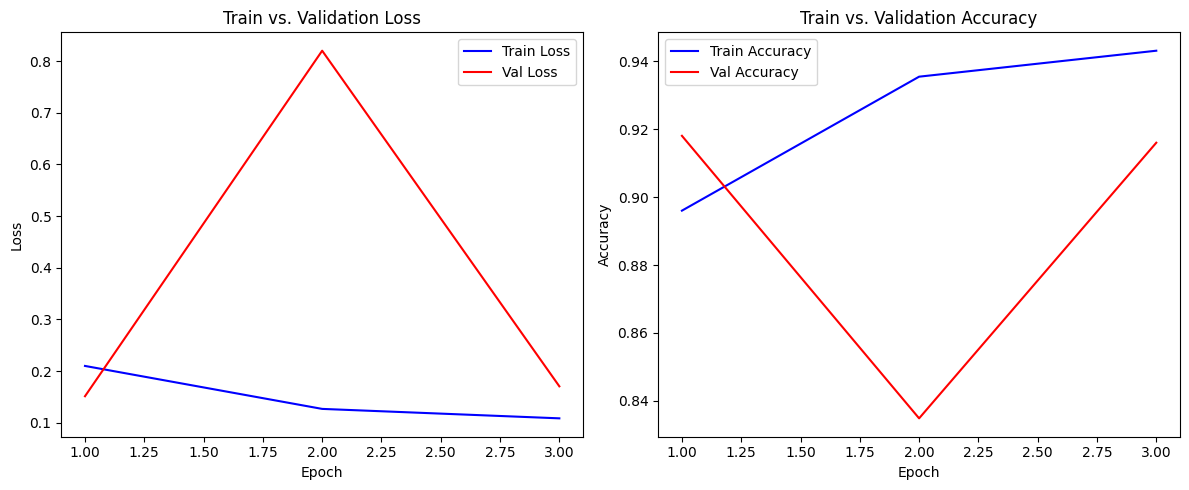

In [62]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label="Train Loss")
plt.plot(epochs, val_losses, 'r-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label="Train Accuracy")
plt.plot(epochs, val_accuracies, 'r-', label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs. Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: inval

ResNet Test Metrics
Test Accuracy:  0.9177
Test Precision: 0.9316
Test Recall:    0.9177
Test F1-Score: 0.9196

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1749
           1       0.99      0.88      0.94      3660

    accuracy                           0.92      5409
   macro avg       0.90      0.94      0.91      5409
weighted avg       0.93      0.92      0.92      5409



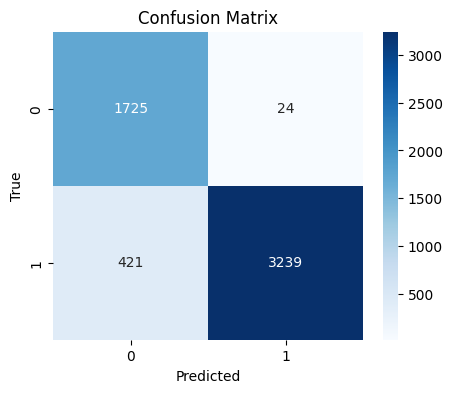

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    return acc, prec, rec, f1, cm, cr

# Evaluate ResNet on test set
acc, prec, rec, f1, cm, cr = evaluate_model(resnet_model, test_loader, device)
print("ResNet Test Metrics")
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(cr)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [64]:
import pandas as pd

# Ringkasan metrik
summary_metrics = {
    'Accuracy': [acc],
    'Precision': [prec],
    'Recall': [rec],
    'F1-Score': [f1]
}

summary_df = pd.DataFrame(summary_metrics)
summary_df.to_csv("resnet_test_summary_metrics.csv", index=False)

In [65]:
cm_df = pd.DataFrame(cm)
cm_df.to_csv("resnet_confusion_matrix.csv", index=False)

In [66]:
from IPython.display import FileLink, display

# Tautan untuk unduh
display(FileLink("resnet_test_summary_metrics.csv"))
display(FileLink("resnet_confusion_matrix.csv"))

/content/resnet_test_summary_metrics.csv

/content/resnet_confusion_matrix.csv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: inval

ResNet Test Metrics
Test Accuracy:  0.9177
Test Precision: 0.9316
Test Recall:    0.9177
Test F1-Score:  0.9196

Classification Report:
              precision    recall  f1-score     support
0              0.803821  0.986278  0.885751  1749.00000
1              0.992645  0.884973  0.935722  3660.00000
accuracy       0.917730  0.917730  0.917730     0.91773
macro avg      0.898233  0.935625  0.910736  5409.00000
weighted avg   0.931589  0.917730  0.919564  5409.00000


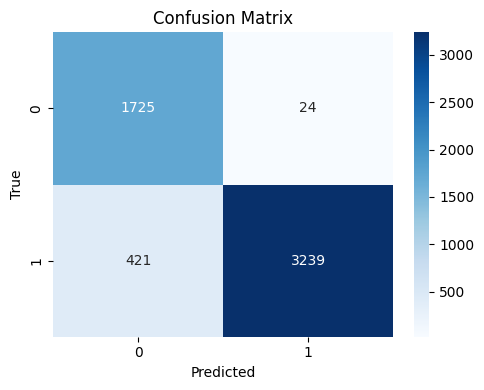

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr_dict = classification_report(all_labels, all_preds, output_dict=True)

    # Simpan classification report ke CSV
    keys_to_extract = ['0', '1', 'macro avg', 'weighted avg']
    metrics_df = pd.DataFrame.from_dict({k: cr_dict[k] for k in keys_to_extract}, orient='index')
    metrics_df.index.name = 'Category'
    metrics_df.reset_index(inplace=True)
    metrics_df['accuracy'] = acc  # tambahkan kolom akurasi
    metrics_df.to_csv('resnet_test_metrics_summary.csv', index=False)

    # Simpan confusion matrix ke CSV
    cm_df = pd.DataFrame(cm, index=[f'True_{i}' for i in range(len(cm))],
                            columns=[f'Pred_{i}' for i in range(len(cm))])
    cm_df.to_csv('resnet_confusion_matrix.csv')

    return acc, prec, rec, f1, cm, cr_dict, all_labels, all_preds

# Evaluasi dan ambil hasil
acc, prec, rec, f1, cm, cr_dict, all_labels, all_preds = evaluate_model(resnet_model, test_loader, device)

# Tampilkan metrik di konsol
print("ResNet Test Metrics")
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1-Score:  {f1:.4f}\n")

print("Classification Report:")
print(pd.DataFrame(cr_dict).transpose())

# Visualisasi confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [68]:
from IPython.display import FileLink
FileLink("resnet_test_metrics_summary.csv")  # dan untuk confusion matrix

/content/resnet_test_metrics_summary.csv

In [69]:
FileLink("resnet_confusion_matrix.csv")

/content/resnet_confusion_matrix.csv

In [70]:
import torch

# Save model checkpoint
torch.save(resnet_model.state_dict(), "resnet_model_checkpoint.pth")
print("Model checkpoint saved as 'resnet_model_checkpoint.pth'.")

# Optionally, save training metrics
import pickle

metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}

with open("resnet_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("Training metrics saved as 'resnet_metrics.pkl'.")


Model checkpoint saved as 'resnet_model_checkpoint.pth'.
Training metrics saved as 'resnet_metrics.pkl'.


In [71]:
from IPython.display import FileLink

FileLink(r'resnet_model_checkpoint.pth')

/content/resnet_model_checkpoint.pth

In [72]:
FileLink(r'resnet_metrics.pkl')

/content/resnet_metrics.pkl

In [73]:
# Re-create the model architecture
loaded_resnet = models.resnet50(pretrained=False)
loaded_resnet.fc = nn.Linear(loaded_resnet.fc.in_features, 2)

# Load the saved state dict
loaded_resnet.load_state_dict(torch.load("resnet_model_checkpoint.pth"))

# Move to device and set to eval mode
loaded_resnet = loaded_resnet.to(device)
loaded_resnet.eval()

print("Model loaded from 'resnet_model_checkpoint.pth' and set to eval mode.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded from 'resnet_model_checkpoint.pth' and set to eval mode.


# Predict

In [74]:
def get_hard_predictions(model, dataloader):
    """
    Returns a list of predicted classes (0 or 1) for all samples in the dataloader.
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                # If the model returns an object with logits (like ViT), extract it.
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            # Get the predicted class
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Get hard predictions from each model (assuming your models are loaded and in eval mode)
resnet_preds = get_hard_predictions(loaded_resnet, test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: inval

In [75]:
import pandas as pd

# Ubah ke DataFrame
df_preds = pd.DataFrame({'prediction': resnet_preds})

# Simpan ke file CSV
df_preds.to_csv('resnet_hard_predictions.csv', index=False)

In [76]:
FileLink(r'resnet_hard_predictions.csv')

/content/resnet_hard_predictions.csv

In [77]:
def get_probabilities(model, dataloader):
    """
    Returns a numpy array of probability distributions for each sample.
    Each row corresponds to a sample and contains probabilities for each class.
    """
    model.eval()
    probabilities = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
            # Convert logits to probabilities
            probs = softmax(outputs)
            probabilities.extend(probs.cpu().numpy())
    return np.array(probabilities)

# Get probability outputs from each model
resnet_probs = get_probabilities(loaded_resnet, test_loader)

<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

In [78]:
# Ubah ke DataFrame
df_probs = pd.DataFrame(resnet_probs, columns=["prob_class_0", "prob_class_1"])

# Simpan ke file CSV
df_probs.to_csv("resnet_probability_predictions.csv", index=False)

print("Probabilitas disimpan ke 'resnet_probability_predictions.csv'")

Probabilitas disimpan ke 'resnet_probability_predictions.csv'


# ViT

In [79]:
from transformers import ViTForImageClassification
import torch.optim as optim
import torch.nn as nn

# Load pre-trained ViT and modify for binary classification
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
vit_model.to(device)
print("ViT model loaded and modified for binary classification.")

# Create an optimizer for ViT (adjust learning rate as needed)
optimizer_vit = optim.AdamW(vit_model.parameters(), lr=5e-5)

# Define loss function if not defined already
criterion = nn.CrossEntropyLoss()

# Hyperparameters for training
num_epochs = 50
patience = 2
early_stop_threshold = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to record training and validation metrics for ViT
vit_train_losses, vit_train_accuracies = [], []
vit_val_losses, vit_val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(vit_model, train_loader, optimizer_vit, criterion, device)
    val_loss, val_acc = validate_epoch(vit_model, val_loader, criterion, device)

    vit_train_losses.append(train_loss)
    vit_train_accuracies.append(train_acc)
    vit_val_losses.append(val_loss)
    vit_val_accuracies.append(val_acc)

    print(f"ViT - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < early_stop_threshold:
        print("Validation loss is negligible; stopping training early.")
        break
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Validation loss did not improve for {patience} consecutive epochs; stopping training.")
            break

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model loaded and modified for binary classification.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: inval

ViT - Epoch 1/50
Train Loss: 0.2118 | Train Acc: 0.8934
Val Loss: 0.1246 | Val Acc: 0.9329


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

ViT - Epoch 2/50
Train Loss: 0.1317 | Train Acc: 0.9274
Val Loss: 0.1290 | Val Acc: 0.9268


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

ViT - Epoch 3/50
Train Loss: 0.1128 | Train Acc: 0.9372
Val Loss: 0.1117 | Val Acc: 0.9366


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

ViT - Epoch 4/50
Train Loss: 0.0921 | Train Acc: 0.9462
Val Loss: 0.0879 | Val Acc: 0.9469


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

ViT - Epoch 5/50
Train Loss: 0.0879 | Train Acc: 0.9475
Val Loss: 0.0987 | Val Acc: 0.9471


<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in divide
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646678951>:63: RuntimeWarning: invalid value encountered in cast
  norm = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
<ipython-input-57-3646

ViT - Epoch 6/50
Train Loss: 0.0837 | Train Acc: 0.9496
Val Loss: 0.1067 | Val Acc: 0.9454
Validation loss did not improve for 2 consecutive epochs; stopping training.


In [80]:
# Save the ViT model after training
torch.save(vit_model.state_dict(), 'vit_model.pth')
torch.save(optimizer_vit.state_dict(), 'optimizer_vit.pth')
print("Model and optimizer state saved.")

Model and optimizer state saved.
